<a href="https://colab.research.google.com/github/analiacuracaram/UGR_DeepLearning/blob/main/Trabajo_Practico_N1_Aprendizaje_Profundo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Alumnas**
      Guadalupe Solé

      Analía Cura Caram

##Readme
Este trabajo se abordó siguiendo la documentación citada en https://www.physionet.org/content/mitdb/1.0.0/

Acorde a como allí se solicita, se cita la fuente de información:

*Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.*

#Paso 1 - Dataset

Documentación wfdb https://physionet.org/content/wfdb-python/3.4.1/

In [1]:
!pip install wfdb #Instalamos el paquete wfdb para poder manejar los waveform, usando el gestor pip (si da error de dependencias con la v de Pandas agregar el flag --use-deprecated=legacy-resolver)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 27.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


##1.1 Importamos el dataset

In [2]:
import wfdb
waveform_db = 'mitdb'

In [3]:
subjects = wfdb.get_record_list(waveform_db)
print(f"La '{waveform_db}' base de datos contiene {len(subjects)} muestras")

La 'mitdb' base de datos contiene 48 muestras


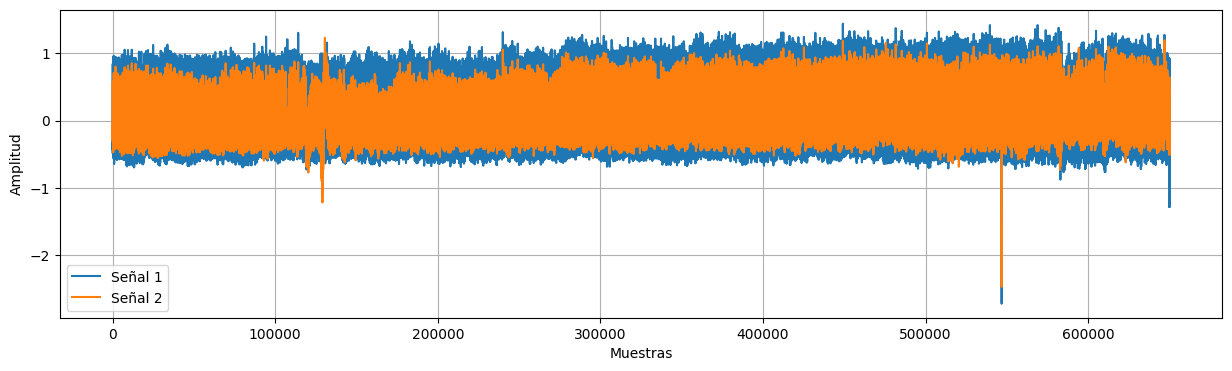

In [4]:
import wfdb
import matplotlib.pyplot as plt

record1 = '100' #Graficamos el primer registro para probar la importación
record = wfdb.rdrecord(record1, pn_dir='mitdb')

plt.figure(figsize=(15, 4))
for i in range(record.p_signal.shape[1]):
    plt.plot(record.p_signal[:, i], label=f'Señal {i+1}')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()


###1.2 Clasificación en 3 clases
Normal(N), Contracción Ventricular Prematura (PVC) y Latido Supraventricular (APB)

In [5]:
import pandas as pd

In [6]:
data = []
clases = ['N', 'V', 'A'] #definimos las clases de interés. "Atrial premature beat=A" es un tipo de latido supraventricular y coincide con las siglas de la consigna

lista_registros = wfdb.get_record_list('mitdb') #Obtenemos la lista de registros

for nombre_registros in lista_registros: #Recorremos los registros
    annotation = wfdb.rdann(nombre_registros, 'atr', pn_dir='mitdb') #Cargamos las anotaciones

    record = wfdb.rdrecord(nombre_registros, pn_dir='mitdb') #Cargamos señal completa, con sus dos canales (nombre del registro y directorio)
    signal = record.p_signal[:, 0]  ##xtraemos el canal 0 que es el principal para manejarlo como un vector (no como una matriz registro/canal)

    for index, label in zip(annotation.sample, annotation.symbol): #Sample son los indices de cada anotación de latido, symbol son las etiquetas. Zip combina ambos valores
        if label in clases: #Filtramos las clases de interés para no recorrer todo
            window_size = 200 #Longitud de ventana razonable https://www.sciencedirect.com/science/article/abs/pii/S1746809413000062
            if index - window_size//2 >= 0 and index + window_size//2 <= len(signal): #Verificamos que el indice de la muestra este dentro de la ventana
                beat = signal[index - window_size//2 : index + window_size//2]
                data.append({
                    'record': nombre_registros,
                    'sample': index,
                    'label': label,
                    'signal': beat
                })

df = pd.DataFrame(data)

print(f"DataFrame construido con {len(df)} latidos.")
df.head()

DataFrame construido con 84703 latidos.


,record,sample,label,signal
0,100,370,N,"[-0.315, -0.3, -0.305, -0.31, -0.32, -0.33, -0..."
1,100,662,N,"[-0.345, -0.345, -0.345, -0.33, -0.33, -0.335,..."
2,100,946,N,"[-0.365, -0.345, -0.345, -0.34, -0.355, -0.365..."
3,100,1231,N,"[-0.35, -0.35, -0.35, -0.34, -0.34, -0.345, -0..."
4,100,1515,N,"[-0.33, -0.315, -0.315, -0.33, -0.33, -0.335, ..."


#Paso 2 - Preprocesamiento

1. Nos enfocamos solo en 3 clases: 'N' → Latido normal (Normal beat). 'V' → Contracción ventricular prematura (PVC),'A' → Latido supraventricular prematuro (APB), descartando otros tipos de latidos
2. Recorremos cada registro de la base MIT-BIH; se filtra toda la señal usando un filtro Butterworth pasa-bajos de 40 Hz para reducir el ruido.  https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
3. Segmentación: Se corta una ventana de 200 milisegundos (72 muestras) alrededor del pico. Se extrae solo la señal que rodea al evento cardíaco.
4. Normalización: Cada ventana segmentada se normaliza: Media = 0, Desviación estándar = 1; de esta forma quedan los latidos comparables entre si.
Cada latido filtrado, segmentado y normalizado se guarda en un DataFrame (df)



##2.1/2.2 Filtrado y Segmentación

In [7]:
## 1. Instalamos e importamos librerías
import numpy as np
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split

In [8]:
# 2. Definimos parámetros
waveform_db = 'mitdb'
clases_interes = ['N', 'V', 'A']  # Nos quedamos solo con las clases de interés
fs = 360  # Definimos la frecuencia de muestreo (Hz)
ventana_muestras = int(0.2 * fs)  # 0.2 segundos alrededor del pico R. * 360 Hz frecuencia = 72 muestras
mitad_ventana = ventana_muestras // 2

In [ ]:
# 3. Definimos funciones
def butter_lowpass_filter(data, cutoff=40, fs=360, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def normalizar_latido(latido):
    return (latido - np.mean(latido)) / np.std(latido)

# 4. Obtenemos lista de registros
lista_registros = wfdb.get_record_list(waveform_db)
print(f"La base de datos '{waveform_db}' contiene {len(lista_registros)} registros.")

# 5. Inicializamos lista para guardar latidos
data = []

# 6. Recorremos registros
for registro in lista_registros:
    print(f"Procesando registro: {registro}...")

    # Carga la señal y anotaciones
    record = wfdb.rdrecord(registro, pn_dir='mitdb')
    annotation = wfdb.rdann(registro, 'atr', pn_dir='mitdb')

    signal = record.p_signal[:, 0]  #Canal principal

    # Filtramos la señal completa una sola vez
    signal_filtrada = butter_lowpass_filter(signal, cutoff=40, fs=360)

    # Recorremos latidos anotados
    for index, label in zip(annotation.sample, annotation.symbol):
        if label in clases_interes:
            inicio = index - mitad_ventana
            fin = index + mitad_ventana
            if inicio >= 0 and fin <= len(signal_filtrada):
                # Segmentamos ventana de 200ms
                latido = signal_filtrada[inicio:fin]

                # Normalizamos el latido
                latido_normalizado = normalizar_latido(latido)

                # Guarda el  latido
                data.append({
                    'record': registro,
                    'sample': index,
                    'label': label,
                    'signal_normalizada': latido_normalizado
                })

# 7. Creamos el DataFrame
df = pd.DataFrame(data)

print(f"\n Procesamiento completo: {len(df)} latidos segmentados, filtrados y normalizados.")
df.head(100)


La base de datos 'mitdb' contiene 48 registros.
Procesando registro: 100...
Procesando registro: 101...
Procesando registro: 102...
Procesando registro: 103...
Procesando registro: 104...
Procesando registro: 105...
Procesando registro: 106...
Procesando registro: 107...
Procesando registro: 108...
Procesando registro: 109...
Procesando registro: 111...
Procesando registro: 112...
Procesando registro: 113...
Procesando registro: 114...
Procesando registro: 115...
Procesando registro: 116...
Procesando registro: 117...
Procesando registro: 118...
Procesando registro: 119...
Procesando registro: 121...
Procesando registro: 122...
Procesando registro: 123...
Procesando registro: 124...
Procesando registro: 200...
Procesando registro: 201...
Procesando registro: 202...
Procesando registro: 203...
Procesando registro: 205...
Procesando registro: 207...
Procesando registro: 208...
Procesando registro: 209...
Procesando registro: 210...
Procesando registro: 212...
Procesando registro: 213...


##2.3 División de datos
•	70% entrenamiento, 15% validación, 15% test (mezcla aleatoria).


In [ ]:

# 1. preparamos X e y
X = np.vstack(df['signal_normalizada'].values)  # Señales (cada fila = 72 muestras)
y = df['label'].values                          # Etiquetas

# 2. dividimos en entrenamiento, validación y test
from sklearn.model_selection import train_test_split

# Primera división: entrenamiento (70%) y "restante" (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Segunda división: validación (15%) y test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Mostramos tamaños
print(f"Tamaño entrenamiento: {len(X_train)} muestras")
print(f"Tamaño validación: {len(X_val)} muestras")
print(f"Tamaño test: {len(X_test)} muestras")


#Paso 3 - Modelado

##3.1 Red Prealimentada (MLP)

In [ ]:
#1. Importamos las librerías necesarias
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
# 2. Definimos la arquitectura de 2 capas densas
model = Sequential([
    Dense(64, activation='relu', input_shape=(200,)),
    Dropout(0.3), #Apagamos el 30% de las neuronas de la capa anterior (valor intermedio entre 0.2 y 0.5 que son los valores habituales)
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # Probabilidad para las 3 clases: N, V, A
])

In [ ]:
# 3. Compilamos el modelo con adam
model.compile(
    optimizer='adam', #Algoritmo más usado y mejor relación velocidad - resultado
    loss='categorical_crossentropy', #Función de perdida para cuando hay + de 2 clases
    metrics=['accuracy'] #Capturamos accuracy para poder evaluar luego
)


In [ ]:
# 3. Prueba con sgd (adicional, descomentar)
# from tensorflow.keras.optimizers import SGD

# model.compile(
#     optimizer=SGD(learning_rate=0.01, momentum=0.9), #Valores estandard
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

In [ ]:
#4. Entrenamos el modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10, #Validamos temprano overfitting
    batch_size=64 #Tardará menos si el lote es grande
)

In [ ]:
#5. Evaluamos el modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Pérdida: {loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')